In [0]:
# Replication of Rich Sutton's TD Learning paper
# http://incompleteideas.net/papers/sutton-88-with-erratum.pdf

In [0]:
import os
import sys
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np


In [0]:
def create_data(transition_matrix):
  seq = [2]
  i = 2 # start at index 2, for D
  # 5 and 6 are terminal states
  while not i >= 5:
    next_obs = np.random.choice(range(len(transition_matrix)), p=transition_matrix[i])
    seq.append(next_obs)
    i = next_obs
  return seq

In [0]:
def delta_w_for_sequence(sequence, x, w, alpha_val, lbda_val):
  delta_w_vals = []

  # print(sequence)
  for t in range(len(sequence) - 1):
    Pt = x[:, sequence[t]].dot(w)
    
    if sequence[t+1] == 5:
      Pt_1 = 0
    elif sequence[t+1] == 6:
      Pt_1 = 1
    else:
      Pt_1 = x[:, sequence[t+1]].dot(w)
    
    sum_past_vals = np.zeros(5)

    for k in range(0, t+1):
      sum_past_vals += lbda_val**(t-k) * x[:, sequence[k]]
    
    delta_w = alpha_val * (Pt_1 - Pt) * sum_past_vals

    delta_w_vals.append(delta_w)

  return delta_w_vals

In [0]:
def compute_delta_for_train_set(train_set, x, w, alpha_val, lbda_val, stochastic=True):
  delta_w_train_set = []
  for k, sequence in enumerate(train_set):
    delta_w_seq = delta_w_for_sequence(sequence, x, w, alpha_val, lbda_val)

    delta_w_seq = np.sum(delta_w_seq, axis=0)

    if stochastic:
        w = w + delta_w_seq

    delta_w_train_set.append(delta_w_seq)
    
  return delta_w_train_set, w


In [0]:
def run_exp_1(training_data, alpha_range, weights, filepath):
    # Experiment 1:
    # Repeated presentations
    # Avg error for different values of lambda, using best alpha
    # best alpha: The alpha value was selected from those shown in Figure 4 (np.arange(0.0, 0.65, 0.05)) to yield the lowest error for that lambda value. 
    # w init: any
    # w update: after all sequences in training set
    # alpha: best
    # lambda: 0, 0.1, 0.3, 0.5, 0.7, 0.9, 1
    # error function: RMSE, averaged over the 100 training sets with true probs (B: 1/6, C: 1/3, D: 1/2, E: 2/3, F: 5/6)
    # outcome: weight vector always converged, no matter initial value, and to same final value
    # best performance for TD(0), perf improved rapidly as λ was reduced below 1, and was best at λ=0


    # Initialize w and feature (x) vectors
    # x = unit basis vectors of length = # of states

    x = np.identity(5)
    true = np.array([1/6, 1/3, 1/2, 2/3, 5/6])

    # Set parameters

    # alpha_range = np.arange(0.0, 0.40, 0.01)    # this gives similar graph as fig 3.
    # alpha_range = np.arange(0.0, 0.65, 0.05)    # this slight variation in graph as fig 3
    lbda_range = [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1]
    decay = 0.9
    tol = 1e-3

    print("alpha_range: ", alpha_range)
    print("weights: ", weights)

    rmse_lbda = []
    sem_lbda = []

    for lbda in lbda_range:
        print()
        print("Lambda: ", lbda)
        rmse_alpha = []
        sem_alpha = []

        for alpha in alpha_range:
            # print()
            # print("Alpha: ", alpha)
            rmse_train = []

            for k, train_set in enumerate(training_data):
                diff = np.inf

                # 0.5 init yields Sutton's graph, random init slightly different depending on alpha range above
                w = weights

                # reset alpha
                a = alpha

                epochs = 0
                while True:
                    epochs += 1
                    delta_w_train_set, _ = compute_delta_for_train_set(train_set, x, w, a, lbda, False)

                    delta_w_train_set = np.sum(delta_w_train_set, axis=0)
                    delta_w_train_set = delta_w_train_set / 10

                    w_new = w + delta_w_train_set
                    diff = np.sum(w_new-w)

                    w = w_new
                    a = decay * a

                    if epochs > 20 and diff <= tol:
                        break
              
                # calc error of converged w with true
                err = (true - w)**2
                err = np.sum(err)
                err = err / len(w)
                err = np.sqrt(err)

                rmse_train.append(err)

            rmse_alpha.append(np.average(rmse_train))

            sem = np.std(rmse_train)/10
            sem_alpha.append(sem)

        print(rmse_alpha)
        print("best alpha: ", alpha_range[np.argmin(rmse_alpha)])
        print('rmse using best alpha: ', rmse_alpha[np.argmin(rmse_alpha)])

        # rmse_lbda.append(rmse_alpha)
        rmse_lbda.append(rmse_alpha[np.argmin(rmse_alpha)])
        
        sem_lbda.append(sem_alpha[np.argmin(rmse_alpha)])

    print('Standard error: ', sem_lbda)

    err_matrix = np.array(rmse_lbda)
    print(err_matrix)

    plt.plot(lbda_range, err_matrix, color="black", marker='.')

    plt.title('Repeated Presentations: Avg RMSE error for different λ', fontsize=11)
    plt.xlabel('λ', fontsize=9)
    plt.ylabel('Error using best alpha', fontsize=9)
    #plt.savefig(filepath)
    #plt.close()
    plt.show()


In [0]:
def run_exp_2(training_data, weights, filepath):
    # Experiment 2:
    # Learning rate analysis
    # Avg error for different values of lambda, using different alpha
    # w init: 0.5
    # w update: after each sequence in training set, training set presented only once
    # alpha: np.arange(0.0, 0.65, 0.05)
    # lambda: 0, 0.3, 0.8, 1
    # error function: RMSE, averaged over the 100 training sets with true probs (B: 1/6, C: 1/3, D: 1/2, E: 2/3, F: 5/6)
    # outcome: Best results at intermediate values of alpha. All λ values less than 1 superior to λ=1 case
    # best value at 0.3 not 0

    # Initialize w and feature (x) vectors
    # x = unit basis vectors of length = # of states

    x = np.identity(5)
    true = np.array([1/6, 1/3, 1/2, 2/3, 5/6])

    # Set parameters

    alpha_range = np.arange(0.0, 0.65, 0.05)
    lbda_range = [0, 0.3, 0.8, 1]
    decay = 0.95
    tol = 1e-3

    rmse_lbda = []
    for lbda in lbda_range:
      print("Lambda: ", lbda)
      rmse_alpha = []
      
      for alpha in alpha_range:
        # print("Alpha: ", alpha)
        rmse_train = []

        for train_set in training_data:
          w = weights
          delta_w_train_set, w = compute_delta_for_train_set(train_set, x, w, alpha, lbda, True)

          delta_w_train_set = np.sum(delta_w_train_set, axis=0)

          err = (true - w)**2
          err = np.sum(err)
          err = err / len(w)
          err = np.sqrt(err)

          rmse_train.append(err)
        
        print(np.average(rmse_train))
        rmse_alpha.append(np.average(rmse_train))
      rmse_lbda.append(rmse_alpha)

    print(np.array(rmse_lbda))

    err_matrix = np.array(rmse_lbda)

    lines = ['-', '--', '-.', ':']
    for i in range(len(err_matrix)):
      vals = err_matrix[i][:11]
      
      plt.plot(alpha_range[:11], vals, marker='.', linestyle=lines[i], label="λ : {}".format(lbda_range[i]))

    plt.xlabel('α', fontsize=9)
    plt.ylabel('Average RMSE', fontsize=9)
    plt.title("Learning rate analysis", fontsize=11)
    plt.legend(loc="best")

    #plt.savefig(filepath)
    #plt.close()
    plt.show()


In [0]:
def main():
    seed = 4

#    if len(sys.argv) == 2:
#      seed = int(sys.argv[1])

    path = "output/seed" + str(seed)

#    if not os.path.exists(path):
#      os.makedirs(path)

    np.random.seed(seed)

    # CREATE TRAINING DATA
    # Define transition matrix of random walk
    # A, G are terminal states, with reward 0, and 1 respectively. 

    transition_matrix = np.zeros((7,7))
    transition_matrix[0, 1] = transition_matrix[0, -2] = 0.5
    transition_matrix[1, 0] = transition_matrix[1, 2] = 0.5
    transition_matrix[2, 1] = transition_matrix[2, 3] = 0.5
    transition_matrix[3, 2] = transition_matrix[3, 4] = 0.5
    transition_matrix[4, 3] = transition_matrix[4, -1] = 0.5
    transition_matrix[5, 5] = transition_matrix[6, 6] = 1.0

    # Create training data sets 100, each consisiting of 10 sequences

    train_set_len = 10
    train_data_len = 100

    training_data = []
    for i in range(train_data_len):
      train_set = []
      for i in range(train_set_len):
        train_set.append(create_data(transition_matrix))
      training_data.append(train_set)

    # get stats of training data
    h = []
    for train_set in training_data:
        for j in train_set:
            h.append(len(j))

    print("Stats of training data")
    print('Median: {}, Min: {}, Max: {}'.format(np.median(h), np.min(h), np.max(h)))
    plt.hist(h, density=True)      #use this to draw histogram of your data
    #plt.savefig(path + "/data_stats.png")
    #plt.close()
    plt.show()

    ##### RUN EXPERIMENTS
    # Run experiments
    # Experiment 1
    # alpha range: alpha_range = np.arange(0.0, 0.65, 0.05) 
    alpha_range = np.arange(0.0, 0.65, 0.05)
    wgts = np.random.rand(5)
    run_exp_1(training_data, alpha_range, wgts, filepath=path + "/figure_3_regular_alpha_range.png")

    # Experiment 2 - Learning rate analysis
    wgts = np.full(5, 0.5)
    run_exp_2(training_data, wgts, filepath=path + "/figure_4.png")


Stats of training data
Median: 8.0, Min: 4, Max: 48


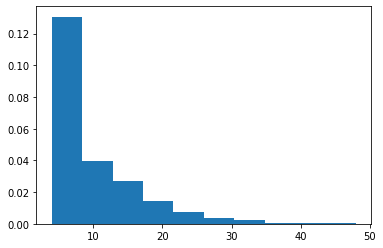

alpha_range:  [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6 ]
weights:  [0.5665028  0.69958221 0.65611327 0.44388931 0.67981327]

Lambda:  0
[0.27984877528796087, 0.21014308417321814, 0.16534533265862922, 0.13425993895748342, 0.11335190192911641, 0.1005980080385663, 0.09396898366041859, 0.09175038299283679, 0.09260415436692665, 0.09494557270943904, 0.09767932651519706, 0.1003630198715507, 0.10284642356045152]
best alpha:  0.35000000000000003
rmse using best alpha:  0.09175038299283679

Lambda:  0.1
[0.27984877528796087, 0.20695539139090322, 0.16089422109939439, 0.12984762409437228, 0.1098919819476998, 0.09851067519709718, 0.09325075333517593, 0.09243831353914757, 0.09433237494204322, 0.09713987772321579, 0.10005584130709737, 0.10279294811706306, 0.1052471358065184]
best alpha:  0.35000000000000003
rmse using best alpha:  0.09243831353914757

Lambda:  0.3
[0.27984877528796087, 0.19967890340895006, 0.15124030580226747, 0.12110755406599097, 0.10404247985984633, 0.096045

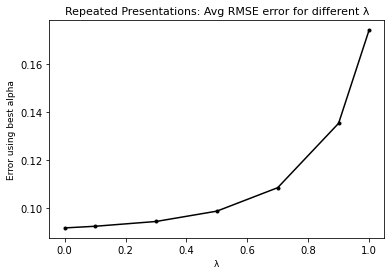

Lambda:  0
0.23570226039551584
0.17504407305207742
0.13131813697238365
0.10372501965716222
0.0919505232462102
0.09509301931230124
0.11429479156209796
0.16012548077142313
0.26705608631858635
0.5155829383969862
1.0854439868199361
2.375502055439257
5.197153913328164
Lambda:  0.3
0.23570226039551584
0.16612450375095567
0.12093500664758296
0.09722252105895449
0.09168023082877508
0.09931663573026978
0.11492969672781297
0.1387880798304035
0.17738451196630733
0.2439690935170473
0.3606632208723914
0.5608310632023609
0.9018490969177501
Lambda:  0.8
0.23570226039551584
0.15250015588195942
0.1245022388762758
0.12987498275552947
0.14879541117629116
0.17192460447764443
0.197252185200197
0.225479735371487
0.2579054296667167
0.2973361258173216
0.3497241456014861
0.4220808899419034
0.5272949871856113
Lambda:  1
0.23570226039551584
0.1879417881846143
0.22137480969100842
0.2741722554393305
0.33380897805177634
0.39831229101604765
0.47055967623665546
0.5573432383699142
0.6782244615042704
0.8550922871325883

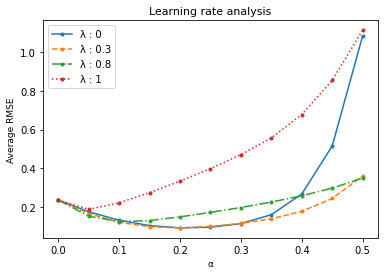

In [0]:
main()